# Initialization

In [1]:
import os
import re
import numpy as np
import random
import time
import json

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
plt.rcParams["font.family"] = "Courier"

%matplotlib inline

In [4]:
set([f.name for f in matplotlib.font_manager.fontManager.afmlist])

{'Computer Modern',
 'Courier',
 'Helvetica',
 'ITC Avant Garde Gothic',
 'ITC Bookman',
 'ITC Zapf Chancery',
 'ITC Zapf Dingbats',
 'New Century Schoolbook',
 'Palatino',
 'Symbol',
 'Times',
 'Utopia',
 'ZapfDingbats'}

### set experiment dates

In [5]:
year = 2005 

### set run

In [6]:
run = 32

In [7]:
run_prefix = 'run_%s_xx' % run

### set directories

In [8]:
dir_root = os.path.join('..')
dir_data_runs = os.path.join(dir_root, 'data_runs')
dir_run = os.path.join(dir_data_runs, run_prefix)
dir_reports = os.path.join(dir_run, 'reports')
dir_plots = os.path.join(dir_run, 'interpretation', 't_search_plots')

In [9]:
if not os.path.exists(dir_plots):
    os.makedirs(dir_plots)

### set flags

In [10]:
flag_debug = False
flag_rerun_scan4T = True
flag_run_heldout = True
flag_serialize_findings = True
flag_de_serialize_findings = True
flag_print_tables = False
flag_b_w = False

# Read data reports from files

In [11]:
def read_report(dir_name, file_name):
    file_path = os.path.join(dir_name, file_name)
    result = []
    with open(file_path, 'r') as f_r:
        for text_line in f_r:
            result = result + text_line.strip().split(' ')
    return result        

In [12]:
reports_list = []

if flag_rerun_scan4T:

    regExp = re.compile('[A-Z\d]+\_[A-Z\d]+\-' + str(year) + '\_[\d]+\.txt$')
    reports_of_year = [f for f in os.listdir(dir_reports) if re.search(regExp, f)]
    reports_of_year.sort()
    # for every reports of the year
    for report_name in reports_of_year:
        reports_list.append(read_report(dir_reports, report_name))

    print('Done on %s, number of documents: %s' % (year, len(reports_of_year)))

Done on 2005, number of documents: 234


# Corpus construction

In [13]:
import gensim
import gensim.corpora as corpora

## Create Dictionary

In [14]:
id2word = corpora.Dictionary(reports_list)

## Create Corpus

Shuffle reporst

In [15]:
seed = 193748

Best randon seed is 99

In [16]:
random.Random(seed).shuffle(reports_list)

Split between training and test set

In [17]:
testing_size = len(reports_list) // 10
training_size = len(reports_list) - testing_size

In [18]:
print('Total %s reprorts' % len(reports_list))
print('Training %s reprorts' % training_size)
print('Testing %s reprorts' % testing_size)

Total 234 reprorts
Training 211 reprorts
Testing 23 reprorts


In [19]:
training_corpus = [id2word.doc2bow(text) for text in reports_list[:training_size]]
test_corpus = [id2word.doc2bow(text) for text in reports_list[:-testing_size]]

corpus = [id2word.doc2bow(text) for text in reports_list]

In [20]:
print('Number of unique tokens: %s' %len(id2word))

Number of unique tokens: 14380


view the first document as BOW

In [21]:
if flag_debug:
    print(corpus[:1])

# Find optimal topic number

In [22]:
from gensim.models import CoherenceModel

In [23]:
def scan_T_gensim(dictionary, 
                  training_corpus, 
                  test_corpus, 
                  texts, 
                  limit, 
                  start=2, 
                  step=3, 
                  passes=10, 
                  random_state=100, 
                  run_perplexity=False):
    
    coherence_values = []
    train_p_values = []
    test_p_values = []
    model_list = []
    bound_values = []
    i = 0
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=training_corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=random_state,
            passes=passes,
            alpha='auto',
            per_word_topics=True,
        )
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v_score = coherencemodel.get_coherence()
        coherence_values.append(c_v_score)
        if run_perplexity:         
            train_perplexity = np.exp2(-(model.log_perplexity(training_corpus)))
            train_p_values.append(train_perplexity)

            test_perplexity = np.exp2(-(model.log_perplexity(test_corpus)))
            test_p_values.append(test_perplexity)
        else:
            train_p_values.append(0)
            test_p_values.append(0)
        
        print('Done on indx: %s T: %s, c_v score: %s, Test perplexity: %s' % (i, num_topics, c_v_score, test_perplexity))
        
        i += 1
        
        
    return model_list, coherence_values, train_p_values, test_p_values


In [24]:
min_T = 5
max_T = 60
step_T = 1
passes_T = 30
random_state = 373748

In [25]:
model_list = []
coherence_values = []
train_perplexity_values = []
test_perplexity_values = []

Run with heldout test set

In [26]:
start = time.time()

if flag_rerun_scan4T and flag_run_heldout:
    model_list, coherence_values, train_perplexity_values, test_perplexity_values = scan_T_gensim(
        dictionary=id2word, 
        training_corpus=training_corpus, 
        test_corpus=test_corpus,
        texts=reports_list, 
        start=min_T, 
        limit=max_T, 
        step=step_T,
        passes=passes_T,
        random_state=random_state,
        run_perplexity = True,
    )
    
end = time.time() 

Done on indx: 0 T: 5, c_v score: 0.3402567561653934, Test perplexity: 221.16480287101407
Done on indx: 1 T: 6, c_v score: 0.3280484906255445, Test perplexity: 218.93326524561763
Done on indx: 2 T: 7, c_v score: 0.4111886073084502, Test perplexity: 212.7794814412897
Done on indx: 3 T: 8, c_v score: 0.37675425842780685, Test perplexity: 210.5132623489937
Done on indx: 4 T: 9, c_v score: 0.3689673423104716, Test perplexity: 208.83814504973503
Done on indx: 5 T: 10, c_v score: 0.4154431935571923, Test perplexity: 205.56586547060147
Done on indx: 6 T: 11, c_v score: 0.4453725833785898, Test perplexity: 204.3657854692683
Done on indx: 7 T: 12, c_v score: 0.4575605851883737, Test perplexity: 200.21137345577813
Done on indx: 8 T: 13, c_v score: 0.45273524201974935, Test perplexity: 199.21520589228993
Done on indx: 9 T: 14, c_v score: 0.4663389537876645, Test perplexity: 198.04111267962958
Done on indx: 10 T: 15, c_v score: 0.4419967671433655, Test perplexity: 196.48091506928722
Done on indx: 1

In [27]:
print('Execution time: %s minutes' % ((end - start)/60))

Execution time: 282.59365118344624 minutes


Run without heldout test set

In [28]:
if not flag_run_heldout and flag_rerun_scan4T:
    model_list, coherence_values, train_perplexity_values, test_perplexity_values = scan_T_gensim(
        dictionary=id2word, 
        training_corpus=corpus, 
        test_corpus=corpus,
        texts=reports_list, 
        start=min_T, 
        limit=max_T, 
        step=step_T,
        passes=passes_T,
        random_state=random_state,
        run_perplexity = False,
    )

In [29]:
import math
for i in range(len(coherence_values)):
    if math.isnan(coherence_values[i]):
        coherence_values[i] = 0

### serialize findings

In [30]:
scat_T_results = {
    'coherence_values': coherence_values, 
    'test_perplexity_values': test_perplexity_values,
}

if flag_serialize_findings and flag_rerun_scan4T:
    with open(os.path.join(dir_run, 'scan_T_values.json'), 'w') as f_w:
        f_w.write(json.dumps(scat_T_results))

### de-serialize findings

In [31]:
if flag_de_serialize_findings:
    coherence_values = []
    test_perplexity_values = []
    
    with open(os.path.join(dir_run, 'scan_T_values.json'), 'r') as f_w:
        data = json.load(f_w)
        coherence_values = data['coherence_values']
        test_perplexity_values = data['test_perplexity_values']

# Results

In [32]:
best_T_on_perplexity = None
best_T_on_coherence = None

In [33]:
topics_range = np.array(range(min_T, max_T + 1, step_T))
best_T_on_perplexity = topics_range[np.argmin(test_perplexity_values)]
best_T_on_coherence = topics_range[np.argmax(coherence_values)]

In [34]:
color_coherence = '#1f94f9'#hsl(208, 95%, 55%) # #1f94f9
color_perplexity = '#f9591f' #hsl(16, 95%, 55%) # #f9591f
color_highlight = 'green'

if flag_b_w: 
    color_coherence = 'black'
    color_perplexity = 'black'
    color_highlight = 'gray'

## Compute PCR

In [35]:
def get_PCR(topics, perplexities):
    pcrs = [0]
    for i in range(1, len(topics)):
        pcr = ((perplexities[i] - perplexities[i - 1]) / (topics[i] - topics[i - 1]))
        pcrs.append(pcr)
        
    return pcrs

In [36]:
rpc_values = get_PCR(topics_range, test_perplexity_values)

## Compute normalized Perplexity

In [37]:
def get_normalized_perplexity(topics, perplexities):
    ps = []
    for t, p in zip(topics, perplexities):
        ps.append(p/t)
        
    return ps

In [38]:
normalised_perplexity_values = get_normalized_perplexity(topics_range, test_perplexity_values)

## Plot

In [39]:
def plot_topics_metric(ax, data, metric = '', label = '', color = 'red', best_is_max = True, with_interest_area = False, interest_area_center = 0, interest_area_size = 5):
    x = np.array(range(min_T, max_T + 1, step_T))
    y = np.array(data)

    ax.set_xlabel('Number of Topics, T')
    ax.set_ylabel(metric, color=color)
    ax.plot(x, y, color=color, label = label)   
    
    x_best = None
    y_best = None
    if with_interest_area:
        interest_area_min = interest_area_center - interest_area_size;
        interest_area_max = interest_area_center + interest_area_size;
        ax.axvspan(interest_area_min, interest_area_max, color=color_highlight, alpha=0.2) 

        x_best = interest_area_min + np.argmax(y[interest_area_min - min_T : (interest_area_max + 1) - min_T])
        y_best = y[interest_area_min - min_T : (interest_area_max + 1) - min_T].max()
    else: 
        if best_is_max:
            x_best = x[np.argmax(y)]
            y_best = y.max()
        else:
            x_best = x[np.argmin(y)]
            y_best = y.min()            

    text = 'Num of Topics=%s, score=%f' % (x_best, y_best)

    bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
    arrowprops=dict(arrowstyle='->')
    kw = dict(xycoords='data',textcoords='axes fraction',
          arrowprops=arrowprops, bbox=bbox_props, ha='right', va='top')
    
    ax.annotate(text, xy=(x_best, y_best), xytext=(0.99,1.1), **kw)


### Plot Perplexity and PCR (Perplexity Change Rate)

findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


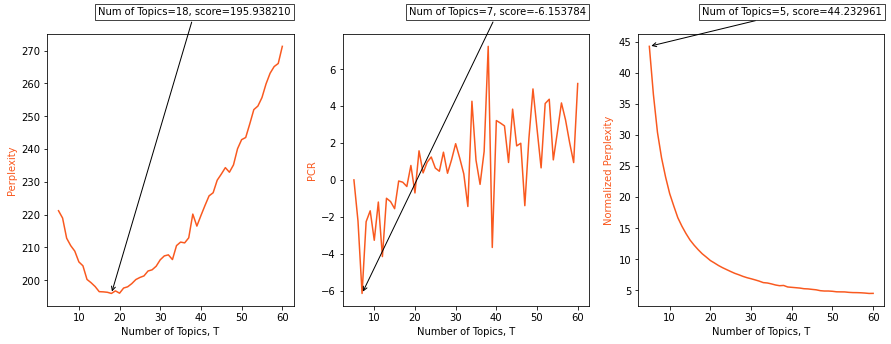

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

plot_topics_metric(
    axs[0], 
    test_perplexity_values,
    metric = 'Perplexity',
    label = 'Test Perplexity',
    color = color_perplexity,
    best_is_max = False
)
plot_topics_metric(
    axs[1], 
    rpc_values,
    metric = 'PCR',
    label = 'Perplexity Change Rate',
    color = color_perplexity,
    best_is_max = False
)
plot_topics_metric(
    axs[2], 
    normalised_perplexity_values,
    metric = 'Normalized Perplexity',
    label = 'Normalized Perplexity',
    color = color_perplexity,
    best_is_max = True
)

plt.show()
plt.close()

### Plot Coherence

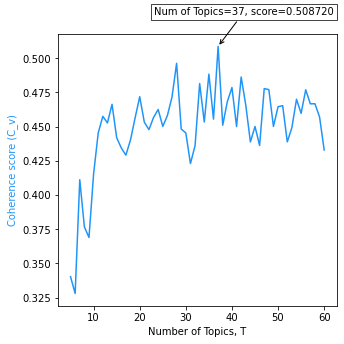

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))


plot_topics_metric(
    ax, 
    coherence_values,
    metric = 'Coherence score (C_v)',
    color = color_coherence,
)

plt.show()
plt.close()

### Plot Coherence with interest area around best perplexity

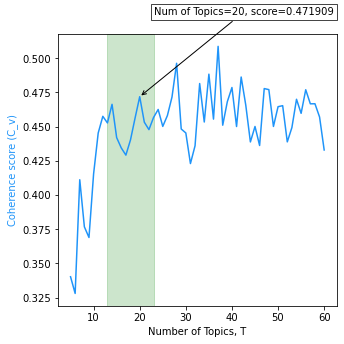

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

plot_topics_metric(
    ax, 
    coherence_values,
    metric = 'Coherence score (C_v)',
    color = color_coherence,
    with_interest_area = True,
    interest_area_center = best_T_on_perplexity
)

plt.show()
plt.close()

### Combined plot

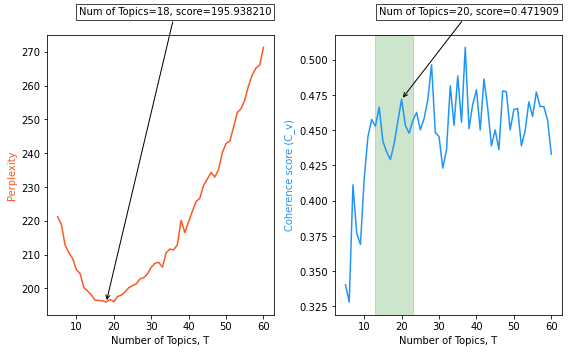

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(8,5))

plot_topics_metric(
    axs[0], 
    test_perplexity_values,
    metric = 'Perplexity',
    color = color_perplexity,
    best_is_max = False
)
plot_topics_metric(
    axs[1], 
    coherence_values,
    metric = 'Coherence score (C_v)',
    color = color_coherence,
    with_interest_area = True,
    interest_area_center = best_T_on_perplexity
)

fig.tight_layout()
pp = PdfPages(os.path.join(dir_plots, 't_scan_combined_plot.pdf'))

plt.savefig(pp, format='pdf', bbox_inches='tight')
plt.show()

pp.close() 

## Tables

In [44]:
all_columns = len(coherence_values)
columns = 6
rows = math.ceil(all_columns / columns)

In [45]:
print('\\begin{table}[h!]')
print('\\centering')
print('\\caption{Scan for T}\\label{tabl_scan_for_t}')
print('\\begin{tabular}{l|%s}' % '|'.join(['c'] * columns))

for r in range(rows):
    start = r * columns
    end = (r + 1) * columns
    
    print('\\hline')
    print('\\textbf{T} & %s \\\\ ' % ' & '.join(['%s' % (x + 5) for x in range(start, end)]))
    print('\\hline')
    print('\\textbf{Coherence score}  & %s \\\\ ' % ' & '.join(['%.4f' % x for x in coherence_values[start:end]]))
    print('\\textbf{Perplexity score} & %s \\\\ ' % ' & '.join(['%.4f' % x for x in test_perplexity_values[start:end]]))
print('\\end{tabular}')
print('\\end{table}')

\begin{table}[h!]
\centering
\caption{Scan for T}\label{tabl_scan_for_t}
\begin{tabular}{l|c|c|c|c|c|c}
\hline
\textbf{T} & 5 & 6 & 7 & 8 & 9 & 10 \\ 
\hline
\textbf{Coherence score}  & 0.3403 & 0.3280 & 0.4112 & 0.3768 & 0.3690 & 0.4154 \\ 
\textbf{Perplexity score} & 221.1648 & 218.9333 & 212.7795 & 210.5133 & 208.8381 & 205.5659 \\ 
\hline
\textbf{T} & 11 & 12 & 13 & 14 & 15 & 16 \\ 
\hline
\textbf{Coherence score}  & 0.4454 & 0.4576 & 0.4527 & 0.4663 & 0.4420 & 0.4345 \\ 
\textbf{Perplexity score} & 204.3658 & 200.2114 & 199.2152 & 198.0411 & 196.4809 & 196.4211 \\ 
\hline
\textbf{T} & 17 & 18 & 19 & 20 & 21 & 22 \\ 
\hline
\textbf{Coherence score}  & 0.4292 & 0.4403 & 0.4564 & 0.4719 & 0.4533 & 0.4478 \\ 
\textbf{Perplexity score} & 196.2958 & 195.9382 & 196.7206 & 196.0134 & 197.5884 & 197.9689 \\ 
\hline
\textbf{T} & 23 & 24 & 25 & 26 & 27 & 28 \\ 
\hline
\textbf{Coherence score}  & 0.4567 & 0.4626 & 0.4502 & 0.4581 & 0.4717 & 0.4963 \\ 
\textbf{Perplexity score} & 198.9299 & 20

## Print top words for best model

In [46]:
best_topics_number = best_T_on_coherence
best_model = model_list[best_topics_number - min_T]

In [47]:
for i in range(best_topics_number):
    print([id2word.id2token[x[0]] for x in best_model.get_topic_terms(i, topn=5)])

['fiscal', 'banking', 'health', 'division', 'exposure']
['aircraft', 'defence', 'air', 'space', 'military']
['mine', 'coca_cola', 'gold', 'mining', 'gallon']
['taxation', 'restate', 'unaudited', 'discontinue', 'medical']
['division', 'client', 'allowance', 'exposure', 'unrealized']
['recognize', 'pro', 'fiscal', 'reinsurance', 'minority']
['care', 'health', 'family', 'beauty', 'merger']
['organic', 'highlight', 'selective', 'watch_jewelry', 'fashion_leather']
['exceptional', 'rental', 'implementation', 'constant', 'pence']
['reinsurance', 'casualty', 'policyholder', 'link', 'amortization']
['gas', 'engineering', 'governance', 'oil', 'construction']
['oil', 'gas', 'natural', 'crude', 'barrel']
['par', 'millions', 'administration', 'valeur', 'pro']
['division', 'mail', 'minority', 'amortization', 'noncurrent']
['banking', 'mortgage', 'holding', 'personal', 'retail']
['salt', 'fertilizer', 'potash_magnesium', 'waste', 'potash']
['coca_cola', 'president', 'beverage', 'water', 'drink']
['ho

In [48]:
best_model.alpha

array([0.01084196, 0.01827498, 0.01672974, 0.0201688 , 0.01819284,
       0.01087475, 0.01759315, 0.01420904, 0.01151859, 0.02278884,
       0.01729787, 0.01483239, 0.01350897, 0.02490131, 0.02966844,
       0.01376495, 0.01488442, 0.01728186, 0.02731157, 0.01924958,
       0.01654838, 0.01788226, 0.02190565, 0.02065962, 0.01882962,
       0.0239159 , 0.01821201, 0.01723304, 0.01642244, 0.02940395,
       0.01706894, 0.05036628, 0.01529409, 0.01988601, 0.01953847,
       0.02037155, 0.02416935], dtype=float32)

# END

In [49]:
best_model.betha

AttributeError: 'LdaModel' object has no attribute 'betha'